In [64]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [65]:
def get_adj(station):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Humidity_adjustments/files/dest_*_relative_humidity_adjusted.nc')[0]
    data = eua.CDMDataset(file).to_dataframe()
    daydata = data[data.time.dt.hour > 6][data.time.dt.hour <= 18]
    nightdata = data[data.time.dt.hour <= 6].append(data[data.time.dt.hour > 18])
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'relative_humidity',
                    'optional':['humidity_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/hur/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/hur/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    return daydata, nightdata, daycdsdata, nightcdsdata

In [66]:
def plt_adj(cdata, adata, plev, station, time, adj, save):
    cdata = cdata[cdata.plev == plev*100]
    adata = adata[adata.plev == plev*100]
    fig, ax = plt.subplots()
    ax.scatter(cdata['time'], cdata.humidity_bias_estimate, label='CDS', s=50)
    ax.scatter(adata['time'], adata.hur_bias_estimate, label='Calc', s=20)

    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Humidity '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Humidity_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

In [67]:
# DOWNLOAD DATA FROM CDS:
home = os.getcwd()
%run gethum.py # downloading just: ['0-20001-0-11035', '0-20001-0-10393', '0-20001-0-70219', '0-20000-0-91413', '0-20000-0-35229', '0-20000-0-68994']
os.chdir(home)

Humidity_adjustments/files


In [68]:
files = glob.glob('Humidity_adjustments/files/downloaded/*/*72357*relative_humidity.nc')
display(files)

['Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity.nc']

In [69]:
# RUN ADJUSTMENTS
import subprocess
for i in files:
    exc = ['./raso_adj_cdm_v1.py', '-f', './'+i, '--humidity', '--verbose']
    list_files = subprocess.run(exc)


2021-07-02 07:57:55,258 INFO Reading Profile on slice(None, None, None)
2021-07-02 07:57:57,561 INFO Welcome to the CDS
2021-07-02 07:57:57,562 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 07:57:57,720 INFO Request is completed
2021-07-02 07:57:57,720 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138190.0704494-16300-4-ebb0fa48-b6a4-4865-b241-6a98472d6bec.zip to download.zip (21.1M)
2021-07-02 07:58:00,581 INFO Download rate 7.4M/s   
2021-07-02 07:58:00,919 INFO Reading Profile on slice(None, None, None)


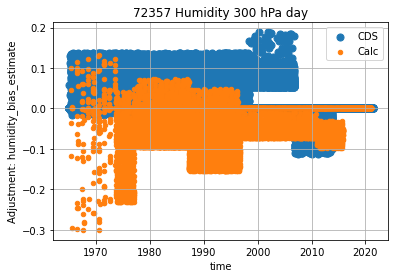

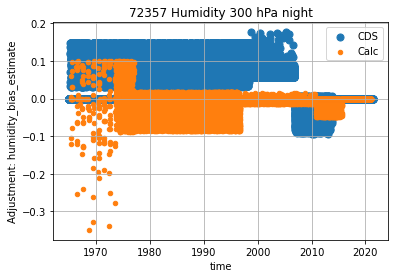

In [74]:
station = '72357'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 300, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 300, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

In [71]:
# station = '91413'
# dd, nd, dcd, ncd = get_adj(station)

# plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-07-02 07:59:04,962 INFO Reading Profile on slice(None, None, None)
2021-07-02 07:59:07,487 INFO Welcome to the CDS
2021-07-02 07:59:07,488 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-02 07:59:07,659 INFO Request is completed
2021-07-02 07:59:07,660 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138448.9778574-12234-15-605fab37-c465-48a5-b154-750282c953fb.zip to download.zip (17.8M)
2021-07-02 07:59:09,897 INFO Download rate 8M/s     
2021-07-02 07:59:10,146 INFO Reading Profile on slice(None, None, None)


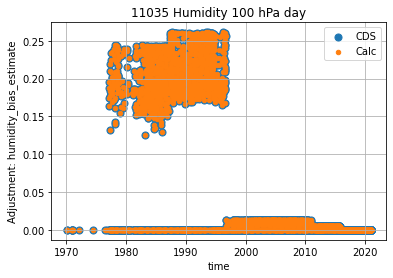

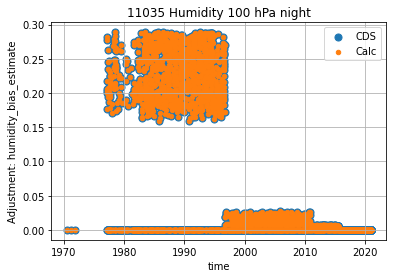

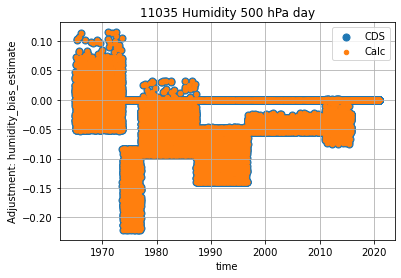

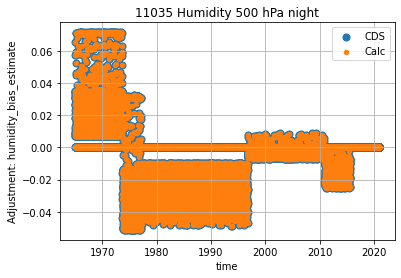

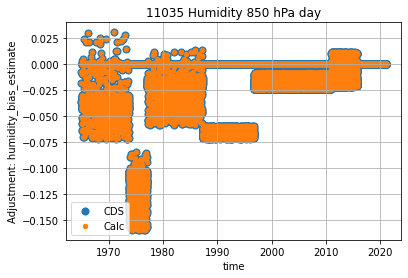

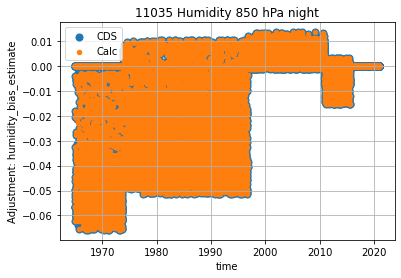

In [75]:
station = '11035'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd[dcd.time > '1965'], dd[dd.time > '1965'], 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd[ncd.time > '1965'], nd[nd.time > '1965'], 850, station, 'night', 'humidity_bias_estimate', save=True)

In [56]:
a = glob.glob('./Humidity_adjustments/files/downloaded/downloaded_72357/*_adjus*')
b = eua.CDMDataset(a[0])
b

File: <HDF5 file "dest_0-20000-0-72357_relative_humidity_adjusted.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 24.06 MB
Filename: ./Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity_adjusted.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (479849,)
 - V | hur__________________________________________ : : (479849,)
 - V | hur_bias_estimate____________________________ : : (479849,)
 - V | hur_breakpoints______________________________ : : (479849,)
 - V | hur_snht_test________________________________ : : (479849,)
 - V | lat__________________________________________ : : (479849,)
 - V | lon__________________________________________ : : (479849,)
 - V | obs__________________________________________ : : (479849,)
 - V | obs_minus_bg_________________________________ : : (479849,)
 - V | plev_________________________________________ : : (479849,)
 - V | report_id____________________________________ : : (479

File: <HDF5 file "dest_0-20000-0-72357_relative_humidity_adjusted.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 24.06 MB
Filename: ./Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity_adjusted.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (479849,)
 - V | hur__________________________________________ : : (479849,)
 - V | hur_bias_estimate____________________________ : : (479849,)
 - V | hur_breakpoints______________________________ : : (479849,)
 - V | hur_snht_test________________________________ : : (479849,)
 - V | lat__________________________________________ : : (479849,)
 - V | lon__________________________________________ : : (479849,)
 - V | obs__________________________________________ : : (479849,)
 - V | obs_minus_bg_________________________________ : : (479849,)
 - V | plev_________________________________________ : : (479849,)
 - V | report_id____________________________________ : : (479

2021-07-01 15:05:18,672 INFO Reading Profile on slice(None, None, None)


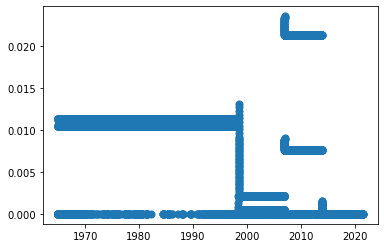

In [63]:
a = glob.glob('./Humidity_adjustments/files/downloaded/downloaded_72357/*_adjus*')
b = eua.CDMDataset(a[0])
display(b)

df = b.to_dataframe(variables=['time', 'hur_bias_estimate', 'hur', 'plev' ])

test = df[df.time > '1965'][df.plev == 85000]

fig, ax = plt.subplots()
ax.scatter(test.time, test.hur_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-01 14:54:42,016 INFO Reading Profile on slice(None, None, None)


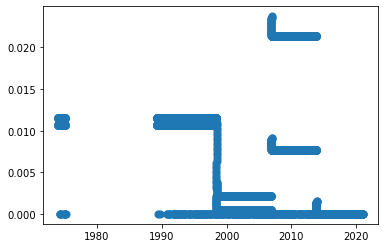

In [62]:
a = glob.glob('/raid60/scratch/leo/scratch/converted_v5/*72357*')
b = eua.CDMDataset(a[0])
b.recordindices['38'][:]

df = b.to_dataframe(groups=['observations_table', 'advanced_homogenisation' ], 
                    variables=['date_time', 'humidity_bias_estimate', 'observed_variable', 'z_coordinate' ])

test = df[df.observed_variable == 38][df.date_time > '1965'][df.z_coordinate == 85000]

fig, ax = plt.subplots()
ax.scatter(test.date_time, test.humidity_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-01 14:53:05,418 INFO Reading Profile on slice(None, None, None)


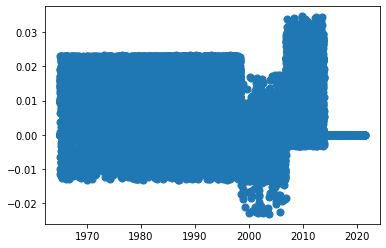

In [61]:
a = glob.glob('/raid60/scratch/leo/scratch/converted_v7/*72357*')
b = eua.CDMDataset(a[0])
b.recordindices['38'][:]

df = b.to_dataframe(groups=['observations_table', 'advanced_homogenisation' ], 
                    variables=['date_time', 'humidity_bias_estimate', 'observed_variable', 'z_coordinate' ])

test = df[df.observed_variable == 38][df.date_time > '1965'][df.z_coordinate == 85000]

fig, ax = plt.subplots()
ax.scatter(test.date_time, test.humidity_bias_estimate, label='CDS', s=50)
plt.show()

2021-07-01 14:24:16,589 INFO Reading Profile on slice(None, None, None)
2021-07-01 14:24:19,003 INFO Welcome to the CDS
2021-07-01 14:24:19,004 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-01 14:24:19,347 INFO Request is queued
2021-07-01 14:24:20,389 INFO Request is running
2021-07-01 14:24:40,401 INFO Request is completed
2021-07-01 14:24:40,403 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1625142273.16007-15730-4-03f339bb-7dbf-4335-8b45-75265c7f36e3.zip to download.zip (31.9M)
2021-07-01 14:24:42,255 INFO Download rate 17.2M/s  
2021-07-01 14:24:42,782 INFO Reading Profile on slice(None, None, None)


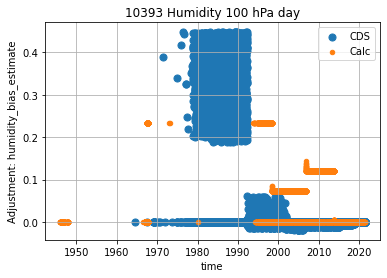

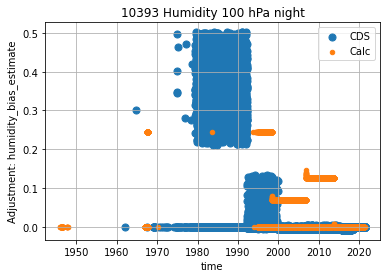

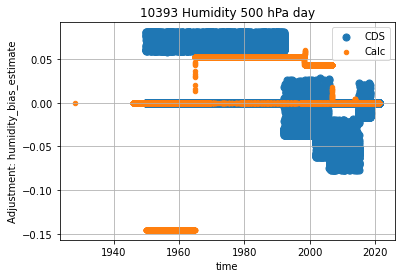

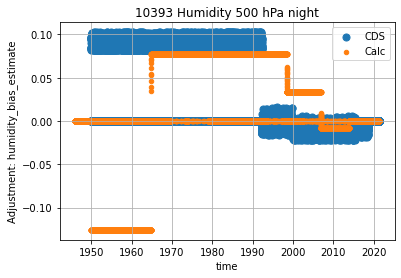

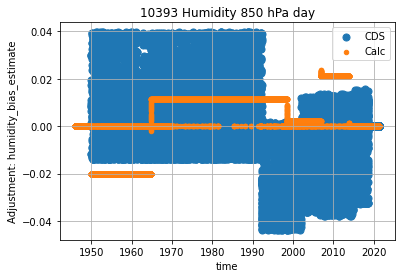

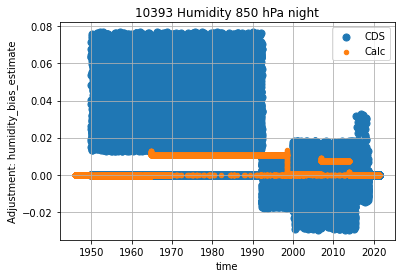

In [11]:
station = '10393'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)